In [1]:
# Necessary libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.model_selection import learning_curve

In [2]:
os.chdir(r"C:\Users\D3\Desktop\Machine Learning\Datasets")

In [3]:
df=pd.read_csv("HR_comma_sep.csv")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
y = df["left"] # dependent(target) variable
X = df.drop(["left","sales","salary"], axis=1) # independent variables

In [5]:
# create GBM model
gbm_model = GradientBoostingClassifier(n_iter_no_change=5,
                                       validation_fraction=0.20,
                                       random_state=17).fit(X,y)

In [6]:
cv_results = cross_validate(gbm_model, X, y, cv=10, scoring=["f1"],
                            return_train_score=True)

print("train f1 score:",cv_results['train_f1'].mean())
print("test f1 score:",cv_results['test_f1'].mean())

# using f1 score for evaluation metric because we have imbalanced dataset
#The gbm classifier model we created gives very good results in both train and test set

train f1 score: 0.9495766606980757
test f1 score: 0.9465580018385509


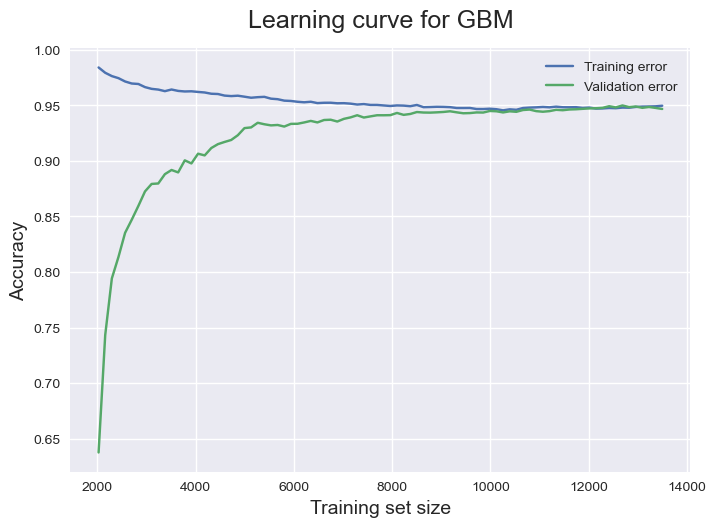

In [7]:
train_sizes, train_scores, test_scores = learning_curve(gbm_model, X, y, cv=10,
                                                        scoring='f1', n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 100))

train_mean = np.mean(train_scores, axis=1)
validation_mean = np.mean(test_scores, axis=1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_mean, label = 'Training error')
plt.plot(train_sizes, validation_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curve for GBM', fontsize = 18, y = 1.03)
plt.legend();

In [8]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

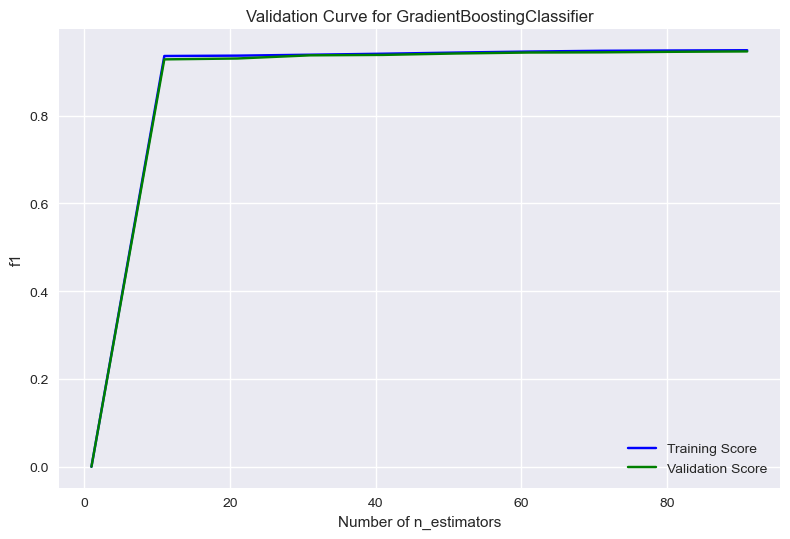

In [9]:
val_curve_params(gbm_model, X, y, "n_estimators", range(1,101,10), scoring="f1")

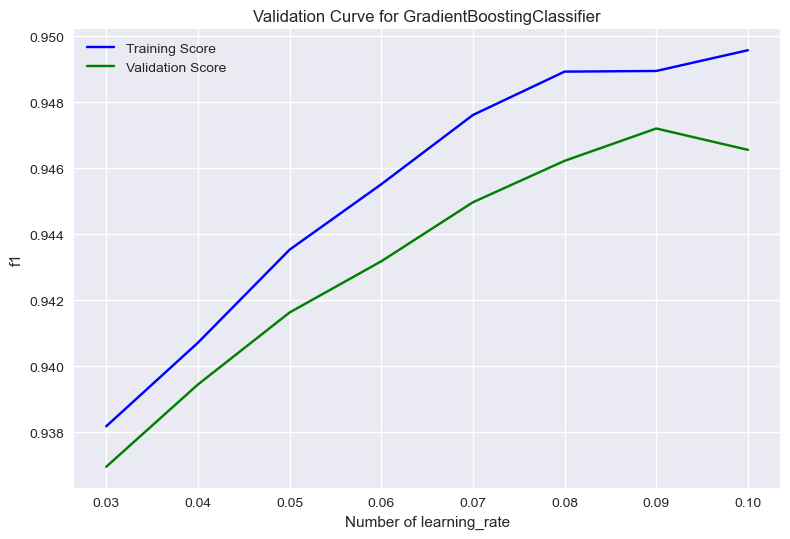

In [10]:
val_curve_params(gbm_model, X, y, "learning_rate", np.arange(0.03,0.1,0.01), scoring="f1")

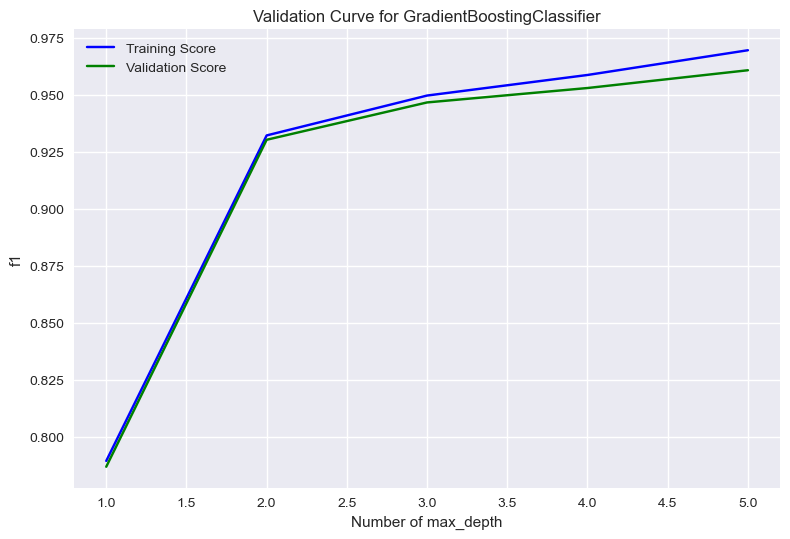

In [11]:
val_curve_params(gbm_model, X, y, "max_depth", range(1,6), scoring="f1")

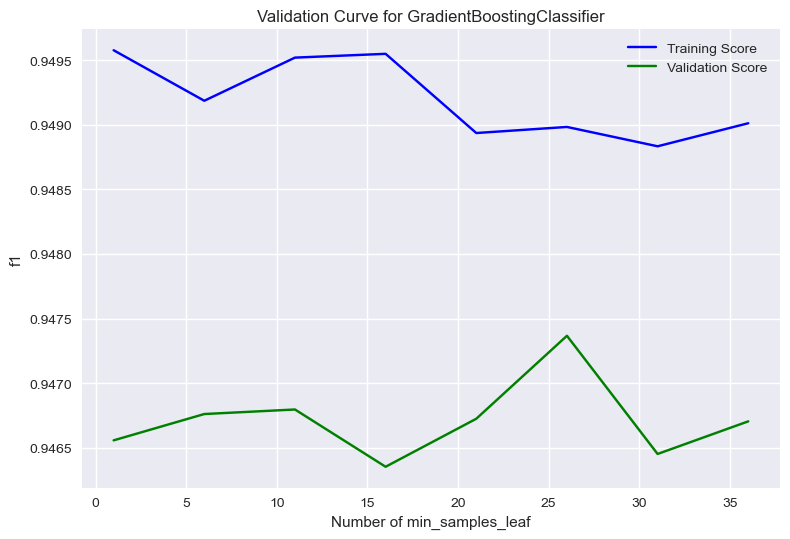

In [12]:
val_curve_params(gbm_model, X, y, "min_samples_leaf", range(1,41,5), scoring="f1")

In [16]:
gbm_params = {"learning_rate": [0.07,0.08],
              "max_depth": [1,2,3],
              "n_estimators": [10,20,30,40,50],
              "subsample": [0.5,0.6],
              "min_samples_split": range(12,16),
              "min_samples_leaf" : range(14,19),
              "max_features":[7,10,13]
             }

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


In [17]:
gbm_best_grid.best_params_

{'learning_rate': 0.08,
 'max_depth': 3,
 'max_features': 7,
 'min_samples_leaf': 17,
 'min_samples_split': 12,
 'n_estimators': 50,
 'subsample': 0.6}

In [18]:
gbm_best_grid.best_score_

0.9670635767478049

In [19]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_,
                                 random_state=17, ).fit(X, y)
# create final model with best gridsearch hyperparameters

In [20]:
cv_results_final = cross_validate(gbm_final, X, y, cv=10, 
                            scoring=["f1"],
                            return_train_score=True)
print("train f1 score:",cv_results_final['train_f1'].mean())
print("test f1 score:",cv_results_final['test_f1'].mean())

train f1 score: 0.9383380843038868
test f1 score: 0.9370738420968147


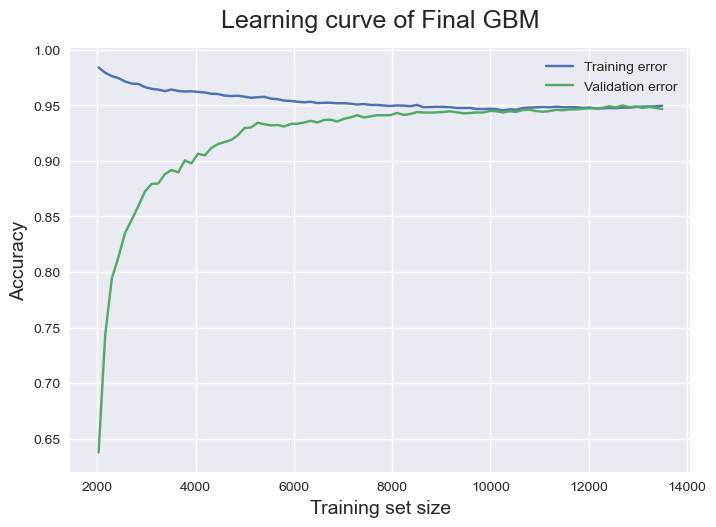

In [21]:
train_sizes_final, train_scores_final, test_scores_final = learning_curve(gbm_final, X, y,
                                                                          cv=10,
                                                        scoring='f1',n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 100))

train_mean_final = np.mean(train_scores_final, axis=1)
validation_mean_final = np.mean(test_scores_final, axis=1)

plt.style.use('seaborn')
plt.plot(train_sizes_final, train_mean, label = 'Training error')
plt.plot(train_sizes_final, validation_mean, label = 'Validation error')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curve of Final GBM', fontsize = 18, y = 1.03)
plt.legend();

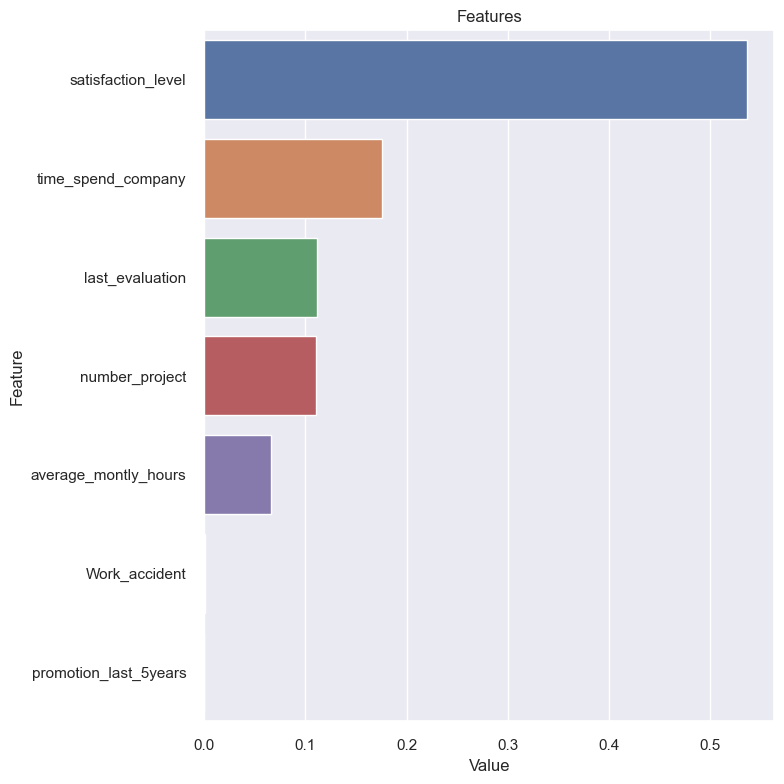

In [22]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(gbm_final, X)